In [1]:
%config InlineBackend.figure_formats = ['svg']

# the main tensor and tensor network functionality
import quimb.tensor as qtn

# backend agnostic array functions
from autoray import do

In [2]:
data = do('random.uniform', size=(3, 4, 5), like='cupy')

In [3]:
inds = ('a', 'b', 'c')

In [4]:
tags = qtn.oset(['hello', 'world'])

In [5]:
T = qtn.Tensor(data=data, inds=inds, tags=tags)
T

Tensor(shape=(3, 4, 5), inds=('a', 'b', 'c'), tags=oset(['hello', 'world']))

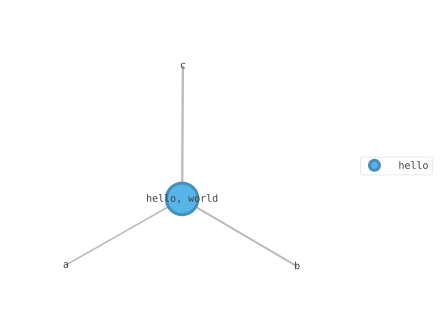

In [6]:
T.draw(color='hello')

In [7]:
T1 = T.fuse({'ac': ('a', 'c')})
T1

Tensor(shape=(15, 4), inds=('ac', 'b'), tags=oset(['hello', 'world']))

In [8]:
T2 = qtn.Tensor(
    # use whatever backend function T1's data is using
    data=do('random.uniform', size=(6, 15), like=T1.data),
    # 'd' is new, 'ac' is shared with T1
    inds=['d', 'ac'],
    tags=['T2'])
T2

Tensor(shape=(6, 15), inds=('d', 'ac'), tags=oset(['T2']))

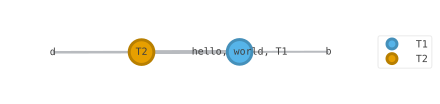

In [9]:
T1.add_tag('T1')
(T1 | T2).draw(color=['T1', 'T2'])

In [10]:
T3 = T1 @ T2  
# == qtn.tensor_contract(T1, T2)
# == T1.contract(T2)
T3

Tensor(shape=(4, 6), inds=('b', 'd'), tags=oset(['hello', 'world', 'T1', 'T2']))

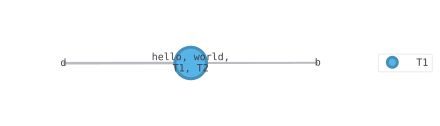

In [11]:
T3.draw(color=['T1'])

In [12]:
def sum_reduce(self, ind, inplace=False):
    """Sum the array axis corresponding to ``ind``.
    """
    # easily enables copy vs inplace version
    t = self if inplace else self.copy()
    
    # get the axis `ind` corresponds to
    axis = t.inds.index(ind)
    
    # use autoray.do to be backend agnostic
    new_data = do('sum', t.data, axis=axis)
    new_inds = t.inds[:axis] + t.inds[axis + 1:]
    
    # update tensor using modify
    t.modify(data=new_data, inds=new_inds)
    
    # return `t` even if inplace to allow method chaining
    return t

sum_reduce(T1, 'b')

Tensor(shape=(15,), inds=('ac',), tags=oset(['hello', 'world', 'T1']))

In [13]:
ta = qtn.rand_tensor((2, 3, 3), ['a', 'x', 'y'], tags='A')
tb = qtn.rand_tensor((2, 3, 3), ['b', 'y', 'z'], tags='B')
tc = qtn.rand_tensor((2, 3, 3), ['c', 'z', 'x'], tags='C')

tn = qtn.TensorNetwork([ta, tb, tc])
tn

<TensorNetwork(tensors=3, indices=6)>

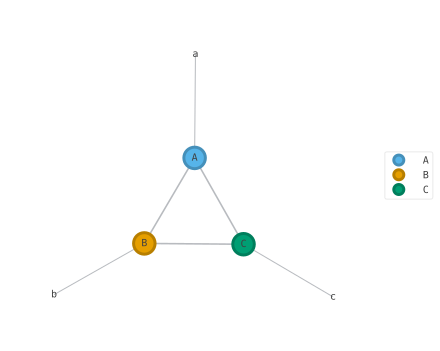

In [14]:
tn.draw(color=['A', 'B', 'C'])

In [15]:
tn.tensor_map

{0: Tensor(shape=(2, 3, 3), inds=('a', 'x', 'y'), tags=oset(['A'])),
 1: Tensor(shape=(2, 3, 3), inds=('b', 'y', 'z'), tags=oset(['B'])),
 2: Tensor(shape=(2, 3, 3), inds=('c', 'z', 'x'), tags=oset(['C']))}

In [16]:
tn.ind_map

{'a': oset([0]),
 'x': oset([0, 2]),
 'y': oset([0, 1]),
 'b': oset([1]),
 'z': oset([1, 2]),
 'c': oset([2])}

For example if we wanted all tensors with the ``'z'`` index, we could call:

In [17]:
[tn.tensor_map[tid] for tid in tn.ind_map['z']]

[Tensor(shape=(2, 3, 3), inds=('b', 'y', 'z'), tags=oset(['B'])),
 Tensor(shape=(2, 3, 3), inds=('c', 'z', 'x'), tags=oset(['C']))]

In [18]:
tn.tag_map

{'A': oset([0]), 'B': oset([1]), 'C': oset([2])}

If we wanted all tensors tagged with ``'B'`` we could call:

In [19]:
[tn.tensor_map[tid] for tid in tn.tag_map['B']]

[Tensor(shape=(2, 3, 3), inds=('b', 'y', 'z'), tags=oset(['B']))]

In [20]:
tn._get_tids_from_tags(['A', 'B'], which='any')

oset([0, 1])

In [21]:
# get the tensor identified by tag 'A'
t = tn['A']  

# inplace rename an index
t.reindex_({'a': 'b'})

# changes are automatically reflected in ``tn``
tn.ind_map

{'x': oset([0, 2]),
 'y': oset([0, 1]),
 'b': oset([1, 0]),
 'z': oset([1, 2]),
 'c': oset([2])}

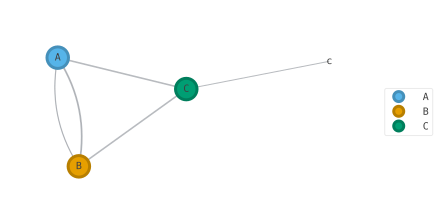

In [22]:
# 'b' should now be traced over
tn.draw(color=['A', 'B', 'C'])

In [23]:
def tanh_neighbors(self, tag, inplace=False):
    """Example function that demonstrates the anatomy of a 
    typical tensor network  method, using ``tensor_map``, 
    ``ind_map``, ``tag_map``, and ``modify``.
    """
    # easily handle both copy and non copy methods
    tn = self if inplace else self.copy()
    
    # get the unique tensor identifiers from our tag
    tids = tn.tag_map[tag]
    
    # collect neighbors in here -> oset for determinism
    neighbors = qtn.oset()
    
    # for every tid in our tagged region
    for tid in tids:
        
        # get the tensor
        t = tn.tensor_map[tid]
        
        # for each of its inds
        for ix in t.inds:
            
            # add all tensors with that index to neighbors
            neighbors |= tn.ind_map[ix]
            
    # now apply tanh to our expanded region
    for tid in neighbors:
        # always use modify and autoray to update tensors
        t = tn.tensor_map[tid]
        t.modify(data=do('tanh', t.data))
    
    # return tn even if self (i.e. inplace) for method chaining
    return tn

qtn.TensorNetwork.tanh_neighbors = tanh_neighbors

# create trailing underscore inplace version
import functools
qtn.TensorNetwork.tanh_neighbors_ =  \
    functools.partialmethod(tanh_neighbors, inplace=True)

In use:

In [24]:
tn['A'].data.item(0)

1.516444583876666

In [25]:
tn.tanh_neighbors_('B')

<TensorNetwork(tensors=3, indices=5)>

In [26]:
# since A is connected to B, its data should have been tanh'd
tn['A'].data.item(0)

0.9080760555088776

In [27]:
tx = qtn.rand_tensor([3, 4], ['a', 'b'], tags='X')
ty = qtn.rand_tensor([4, 5], ['b', 'c'], tags='Y')

tn = tx & ty
# == qtn.TensorNetwork([tx, ty], virtual=False)

tx is tn['X']

False

In [28]:
tn = tx | ty
# == qtn.TensorNetwork([tx, ty], virtual=True)

tx is tn['X']

True

In [29]:
tx is tn.copy(virtual=True)['X']

True

In [30]:
tx = qtn.rand_tensor([3, 4], ['a', 'b'], tags='X')
ty = qtn.rand_tensor([4, 5], ['b', 'c'], tags='Y')
tz = qtn.rand_tensor([4, 5], ['b', 'c'], tags='Z')

tn_xy = tx | ty
tn_xz = tx | tz

tx.owners

{8754986625160: (<weakref at 0x7f66dde40180; to 'TensorNetwork' at 0x7f66dde28880>,
  0),
 8754986625709: (<weakref at 0x7f66dde401d0; to 'TensorNetwork' at 0x7f66dde2aad0>,
  0)}

In [31]:
qtn.MatrixProductState._EXTRA_PROPS

('_site_tag_id', '_site_ind_id', 'cyclic', '_L')

In [32]:
mps = qtn.MPS_rand_state(L=100, bond_dim=20, cyclic=True)
mps.site_tag_id, mps.site_ind_id, mps.cyclic, mps.L

('I{}', 'k{}', True, 100)

In [33]:
mps = qtn.MatrixProductState(
    [
        do('random.normal', size=(7, 2), like='numpy'),
        do('random.normal', size=(7, 7, 2), like='numpy'),
        do('random.normal', size=(7, 7, 2), like='numpy'),
        do('random.normal', size=(7, 2), like='numpy'),
    ], 
    site_ind_id='b{}'
)
mps.site_tag_id, mps.site_ind_id, mps.cyclic, mps.L

('I{}', 'b{}', False, 4)

In [34]:
t00 = qtn.rand_tensor([2, 4, 4], inds=['k0,0', '00-01', '00-10'], tags=['I0,0', 'ROW0', 'COL0'])
t01 = qtn.rand_tensor([2, 4, 4], inds=['k0,1', '00-01', '01-11'], tags=['I0,1', 'ROW0', 'COL0'])
t10 = qtn.rand_tensor([2, 4, 4], inds=['k1,0', '00-10', '10-11'], tags=['I1,0', 'ROW1', 'COL1'])
t11 = qtn.rand_tensor([2, 4, 4], inds=['k1,1', '01-11', '10-11'], tags=['I1,1', 'ROW1', 'COL1'])

These make up a little PEPS-like 2x2 TN:

In [35]:
tn = (t00 | t01 | t10 | t11)
tn

<TensorNetwork(tensors=4, indices=8)>

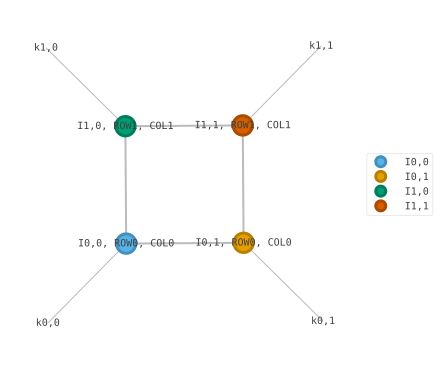

In [36]:
tn.draw(color=['I0,0', 'I0,1', 'I1,0', 'I1,1'])

In [37]:
# we need to tell the constructor what values we are using for the following:
qtn.PEPS._EXTRA_PROPS

('_site_tag_id', '_row_tag_id', '_col_tag_id', '_Lx', '_Ly', '_site_ind_id')

In [38]:
peps = qtn.PEPS.from_TN(
    tn, 
    Lx=2, 
    Ly=2,
    site_tag_id='I{},{}', 
    site_ind_id='k{},{}',
    row_tag_id='ROW{}',
    col_tag_id='COL{}',
)
peps

<PEPS(tensors=4, indices=8, Lx=2, Ly=2, max_bond=4)>

In [39]:
peps.show()

    4   
 ●━━━━●
╱┃4  ╱┃4  
 ┃  4 ┃ 
 ●━━━━●
╱    ╱    


In [40]:
tn.view_as_(
    qtn.tensor_2d.TensorNetwork2DFlat,
    Lx=2, 
    Ly=2,
    site_tag_id='I{},{}',
    row_tag_id='ROW{}',
    col_tag_id='COL{}',
)

<TensorNetwork2DFlat(tensors=4, indices=8, Lx=2, Ly=2, max_bond=4)>

In [41]:
# `tn` is now a 'FLat 2D TN'
tn.show()

    4   
 ●━━━━●
 ┃4   ┃4  
 ┃  4 ┃ 
 ●━━━━●
          


In [42]:
other_peps = qtn.PEPS.rand(Lx=2, Ly=2, bond_dim=5)

tn.view_like_(other_peps)

<PEPS(tensors=4, indices=8, Lx=2, Ly=2, max_bond=4)>

In [43]:
# `tn` is now a PEPS with its special methods
tn.expand_bond_dimension(9).show()

    9   
 ●━━━━●
╱┃9  ╱┃9  
 ┃  9 ┃ 
 ●━━━━●
╱    ╱    


In [44]:
# so if we combine two MPS, which are both TensorNetwork1D
mps_a = qtn.MPS_rand_state(10, 7)
mps_b = qtn.MPS_rand_state(10, 7)

# we get a TensorNetwork1D
mps_a | mps_b

<TensorNetwork1D(tensors=20, indices=28, L=10, max_bond=7)>

In [45]:
# and if we combine two PEPS, which are both TensorNetwork2D
peps_a = qtn.PEPS.rand(10, 10, 7)
peps_b = qtn.PEPS.rand(10, 10, 7)

# we get a TensorNetwork2D
peps_a | peps_b

<TensorNetwork2D(tensors=200, indices=460, Lx=10, Ly=10, max_bond=7)>

In [46]:
T1 = qtn.rand_tensor((2, 2), ('a', 'x'))
T2 = qtn.rand_tensor((2, 2), ('b', 'x'))
T3 = qtn.rand_tensor((2, 2), ('c', 'x'))

# we'll get an error due to 'x' unless we specify output_inds
qtn.tensor_contract(T1, T2, T3, output_inds=['a', 'b', 'c'])

Tensor(shape=(2, 2, 2), inds=('a', 'b', 'c'), tags=oset([]))

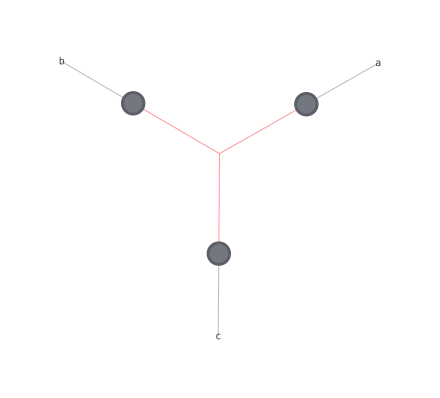

In [47]:
(T1 | T2 | T3).draw(highlight_inds=['x'])